# Aculei notebook

This notebook is a collection of visuals to better understand the aculei dataset.

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
import requests
import matplotlib as mpl

from PIL import Image

font_path = '../assets/Q-04LITE-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

rc_params = {
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 10,
    'figure.figsize': (10, 6),
    'font.weight': 'bold',
    'font.family': 'sans-serif',
    # 'font.sans-serif': prop.get_name(),
    'axes.labelweight': 'bold',
}

plt.rcParams.update(rc_params)

In [2]:
data_folder = '../data/'
image_folder = 'images-compressed/'
d_archive = pd.read_csv(os.path.join(data_folder, 'archive.csv'))
d_experience = pd.read_csv(os.path.join(data_folder, 'experience.csv'))

df = pd.concat([d_archive, d_experience], ignore_index=False).reset_index(drop=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401 entries, 0 to 1400
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1401 non-null   object 
 1   image_name        1401 non-null   object 
 2   predicted_animal  1401 non-null   object 
 3   moon_phase        1245 non-null   object 
 4   temperature       778 non-null    float64
 5   date              1245 non-null   object 
 6   cam               1237 non-null   object 
 7   top_predictions   1401 non-null   object 
dtypes: float64(1), object(7)
memory usage: 87.7+ KB


Filter out crazy temperatures and add month column

In [4]:
df.temperature = df.temperature.apply(lambda x: x if x > -10 and x < 40 else None)

df.date = pd.to_datetime(df.date)

df['cam'] = df.cam.astype(str)
df['cam'] = df.cam.apply(lambda x: x.replace(' ', ''))

In [5]:
palette = sns.color_palette("Set2", n_colors=df['predicted_animal'].nunique())
df.head()

,id,image_name,predicted_animal,moon_phase,temperature,date,cam,top_predictions
0,76288dfbf134376e0b6fae8d8ff87c26,TF_ACULEI_25012021-203.jpg,porcupine,Waxing Gibbous,17.0,2021-01-25 02:01:32,CAM7,"[{'score': 0.9460213780403137, 'label': 'porcu..."
1,b208189a2c8098e96b6fcd072c11973b,TF_ACULEI_09122022-20472.jpg,badger,Full Moon,NaN,2022-12-09 00:26:36,CAM7,"[{'score': 0.5541021227836609, 'label': 'badge..."
2,565a665ece3a28a303341f0bad2438a3,TF_ACULEI_16012021-114.jpg,porcupine,Waxing Crescent,15.0,2021-01-16 02:22:59,CAM7,"[{'score': 0.9885479211807251, 'label': 'porcu..."
3,735612479acffa490cdd3fc5adc11052,TF_ACULEI_17012021-132.jpg,badger,Waxing Crescent,21.0,2021-01-17 04:30:20,CAM7,"[{'score': 0.707364022731781, 'label': 'badger..."
4,0861de2ed9fcbdef288f4a4dbfbf8159,TF_ACULEI_08102022-18350.jpg,wild boar,Waxing Gibbous,13.0,2022-10-08 12:03:42,CAM7,"[{'score': 0.5363767743110657, 'label': 'wild ..."


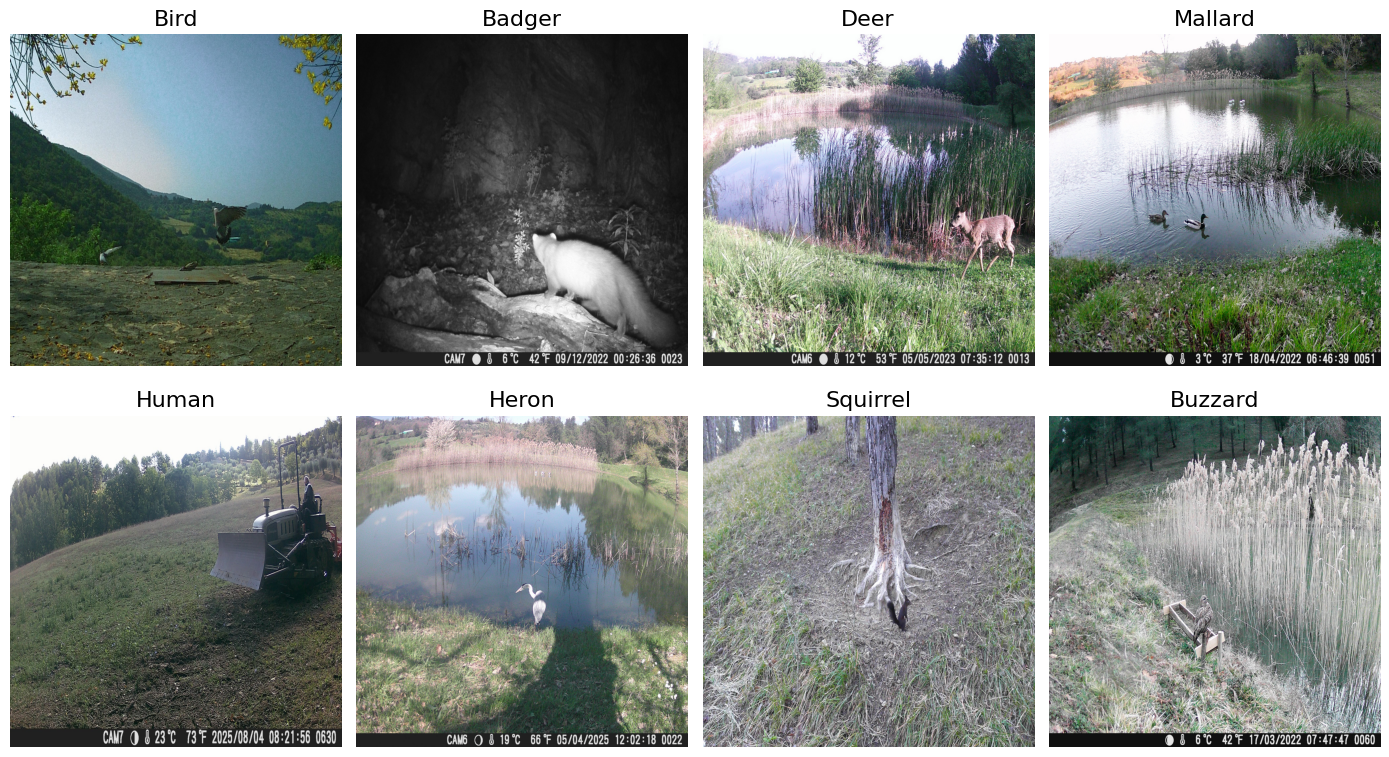

In [29]:
subset = d_archive[~d_archive['cam'].isna()].sample(200).drop_duplicates(subset=['predicted_animal'], keep='last').sample(8).reset_index()
fig, axes = plt.subplots(2, 4, figsize=(14, 8))
for i, row in subset.iterrows():
    path = "https://bucket.aculei.xyz/" + row.image_name
    img = Image.open(requests.get(path, stream=True).raw)
    img = img.resize((2048, 2048))
    ax = axes[i // 4, i % 4]
    ax.imshow(img)
    ax.title.set_fontsize(16)
    ax.title.set_text(str.capitalize(row.predicted_animal))
    ax.axis('off')
plt.tight_layout()
plt.savefig('../assets/sample_images.png', format='png', transparent=False)
plt.show()

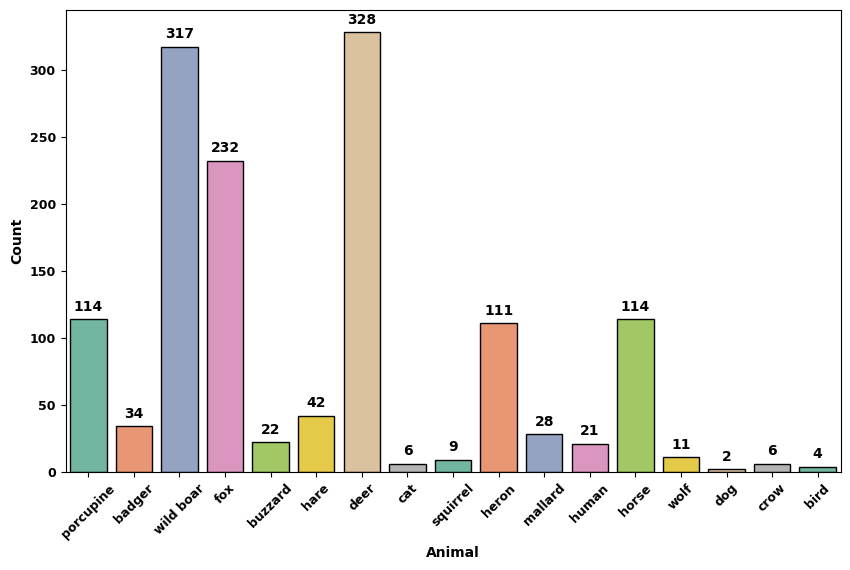

In [30]:
f, ax = plt.subplots()
c = sns.countplot(df, x="predicted_animal", hue="predicted_animal", legend=False, ec="black", ax=ax, palette=palette)

for p in c.patches:
    c.annotate(format(p.get_height(), '.0f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', 
               xytext = (0, 9), 
               textcoords = 'offset points')

ax.set_xlabel('Animal')
ax.set_ylabel('Count')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

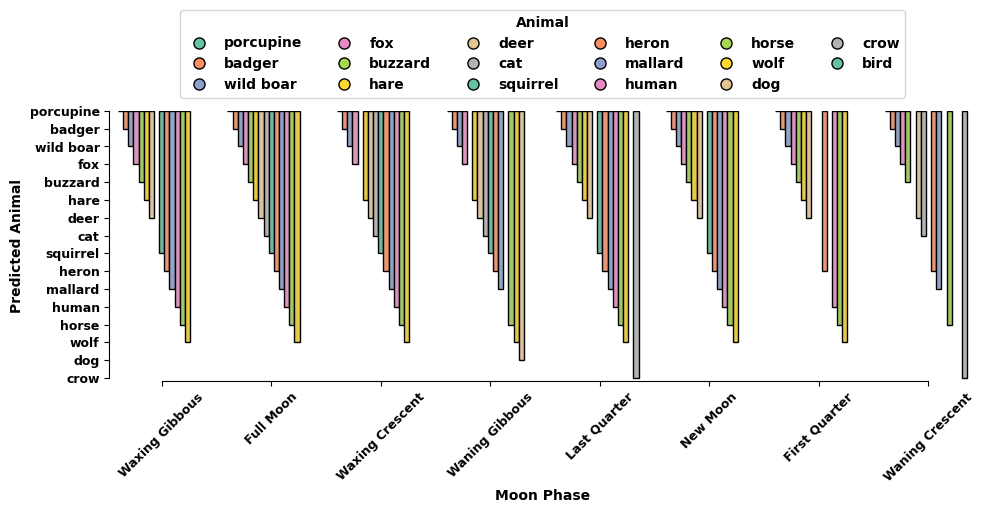

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

v = sns.barplot(
    data=df,
    hue="predicted_animal",
    y="predicted_animal",
    x="moon_phase",
    ax=ax,
    palette=palette,
    ec="black"
)

ax.set_ylabel('Predicted Animal')
ax.set_xlabel('Moon Phase')
# ax.set_title('Moon Phase Distribution for Each Animal', fontsize=14, pad=15)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

v.axes.margins(.01)
sns.despine(trim=True)

unique_animals = df['predicted_animal'].unique()
legend_handles = [
    mpl.lines.Line2D(
        [0], [0],
        label=animal,
        marker='o',
        markerfacecolor=palette[i],
        markeredgecolor='black',
        markersize=8,
        linestyle='None'
    )
    for i, animal in enumerate(unique_animals)
]

ax.legend(
    handles=legend_handles,
    loc='upper center',
    ncol=min(len(unique_animals), 6),
    bbox_to_anchor=(0.5, 1.4),
    frameon=True,
    title="Animal"
)

fig.savefig("../assets/moon_phase.svg", format='svg', bbox_inches='tight')

plt.tight_layout()
plt.show()

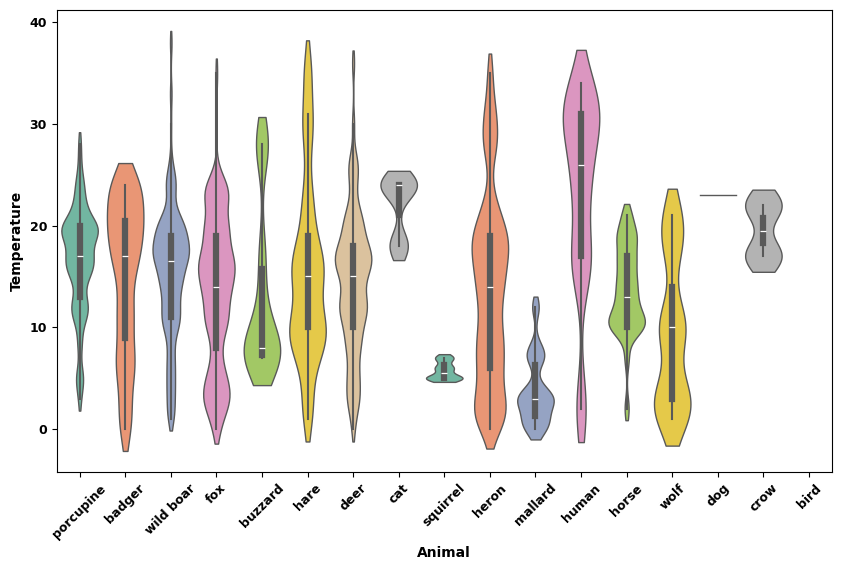

In [32]:
f, ax = plt.subplots()

v = sns.violinplot(data=df, hue="predicted_animal", x="predicted_animal", y="temperature", 
               bw_adjust=.5, cut=1, linewidth=1, legend=False, ax=ax, palette=palette)

ax.set_ylabel('Temperature')
ax.set_xlabel('Animal')

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# v.axes.margins(.02)
# sns.despine(trim=True)

plt.show()

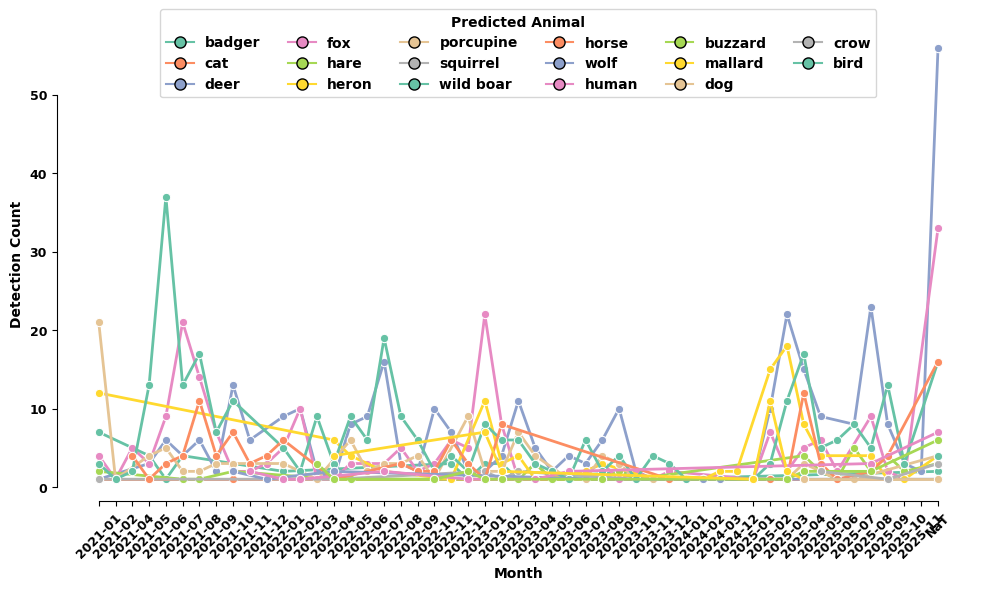

In [10]:
dd = df.copy()
dd['day'] = dd.date.dt.date
dd['month'] = dd.date.dt.to_period('M').astype(str)
dd = dd.groupby(['month', 'predicted_animal']).size().reset_index(name='count')

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    x="month",
    y="count",
    hue="predicted_animal",
    data=dd,
    palette=palette,
    linewidth=2,
    ax=ax,
    marker='o',
)

ax.set_xlabel("Month")
ax.set_ylabel("Detection Count")
plt.xticks(rotation=45)
sns.despine(trim=True)

unique_animals = dd['predicted_animal'].unique()
legend_handles = [
    mpl.lines.Line2D(
        [0], [0],
        label=animal,
        color=palette[i],
        marker='o',
        markerfacecolor=palette[i],
        markeredgecolor='black',
        markersize=8,
        linestyle='-'
    )
    for i, animal in enumerate(unique_animals)
]

ax.legend(
    handles=legend_handles,
    loc='upper center',
    ncol=min(len(unique_animals), 6),
    bbox_to_anchor=(0.5, 1.05),
    frameon=True,
    title="Predicted Animal"
)

plt.tight_layout()
plt.show()

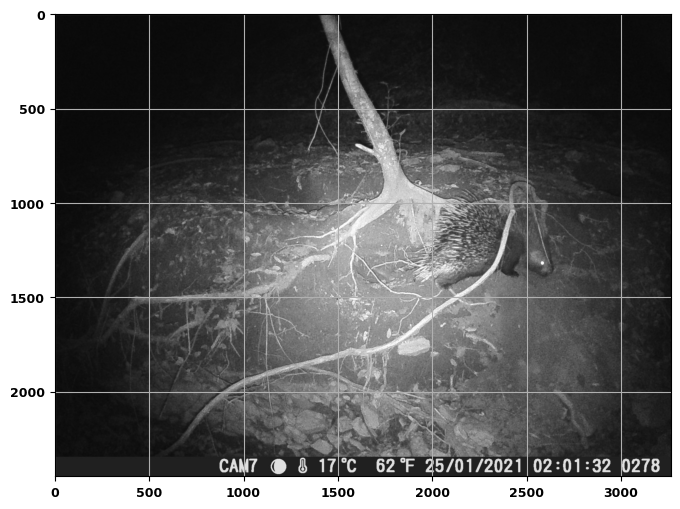

In [11]:
from PIL import Image

image_path = "https://bucket.aculei.xyz/" + df.iloc[0]['image_name']
img = Image.open(requests.get(image_path, stream=True).raw)
plt.imshow(img)
plt.grid('on')
plt.show()